In [ ]:
!pip install opendatasets --quiet


In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omaratef3221
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 660MB/s] 


In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU
print(f"the available device is: {device}")

the available device is: cuda


In [ ]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")
# data_df = pd.concat([train_df, val_df], ignore_index=True)

train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]

print("Data shape is: ", train_df.shape)
train_df.head()

Data shape is:  (1034, 2)


,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [ ]:
# print("Classes are: ")
# print(data_df["category"].unique())
# print()
# print("Classes ditrubution are: ")
# print(data_df["category"].value_counts())

In [ ]:
label_encoder = LabelEncoder() # Encode the string classes to numeric

transform = transforms.Compose([
    transforms.Resize((128, 128)), # make all image in one size
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float), # The values are in floating point numbers
    ]) # Transform all images into one clear format

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = (self.transform(image)/255).to(device)

    return image, label

In [ ]:
train_dataset = CustomImageDataset(dataframe=train_df, transform=transform)
val_dataset = CustomImageDataset(dataframe=val_df, transform=transform)

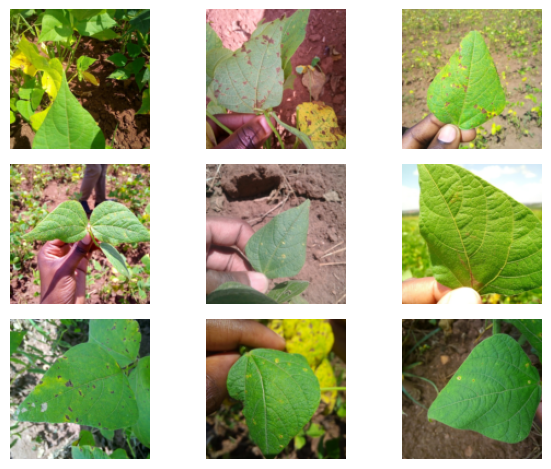

In [ ]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255.0).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = True

In [ ]:
googlenet_model.fc
num_classes = len(train_df["category"].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(googlenet_model.parameters(), lr=LR) # Adam optimizer

In [ ]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')

Epoch 1/15, Train Loss: 2.411 Train Accuracy 53.3849%
Epoch 2/15, Train Loss: 2.2292 Train Accuracy 62.6692%
Epoch 3/15, Train Loss: 2.1179 Train Accuracy 65.9574%
Epoch 4/15, Train Loss: 1.9151 Train Accuracy 68.2785%
Epoch 5/15, Train Loss: 1.7093 Train Accuracy 73.0174%
Epoch 6/15, Train Loss: 1.6768 Train Accuracy 73.6944%
Epoch 7/15, Train Loss: 1.7063 Train Accuracy 73.3075%
Epoch 8/15, Train Loss: 1.5459 Train Accuracy 75.5319%
Epoch 9/15, Train Loss: 1.3735 Train Accuracy 79.1103%
Epoch 10/15, Train Loss: 1.1833 Train Accuracy 82.0116%
Epoch 11/15, Train Loss: 1.3229 Train Accuracy 78.2398%
Epoch 12/15, Train Loss: 1.1489 Train Accuracy 83.4623%
Epoch 13/15, Train Loss: 1.1742 Train Accuracy 82.205%
Epoch 14/15, Train Loss: 0.9298 Train Accuracy 86.3636%
Epoch 15/15, Train Loss: 0.988 Train Accuracy 85.4932%


In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  # for indx, (input, labels) in enumerate(val_loader):
  for input, labels in val_loader:

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/val_dataset.__len__())*100, 2)}%")

Accuracy Score is: 86.47%


In [ ]:
# Function to predict on a single image
def predict_image(image_path, model, transform, label_encoder, device):
    model.eval()  # Set model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image = transform(image)/255  # Apply same transforms as training
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]
        confidence = probabilities[0][predicted_class].item() * 100

    return predicted_label, confidence

# Upload an image and predict
print("Please upload an image for prediction:")
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name
predicted_label, confidence = predict_image(image_path, googlenet_model, transform, label_encoder, device)
print(f"Predicted Class: {predicted_label}, Confidence: {confidence:.2f}%")


Please upload an image for prediction:


Saving bean-leaves.jpg to bean-leaves.jpg
Predicted Class: 1, Confidence: 50.84%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(googlenet_model.state_dict(), '/content/drive/MyDrive/googlenet_model.pth')
print("model saved success")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
model saved success
